In [3]:
using LightGraphs, MetaGraphs, CSV, DataFrames, GraphDataFrameBridge

In [4]:
using GraphPlot, LinearAlgebra, Plots
BLAS.set_num_threads(10)
using Statistics

In [241]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


In [5]:
file = "../data/interim/costanzo_pcc_ALL"

"../data/interim/costanzo_pcc_ALL"

In [6]:
df = CSV.read(file);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `CSV.read(input, DataFrame; kw...)
└ @ CSV /home/oma21/.julia/packages/CSV/fOEbk/src/CSV.jl:41


In [7]:
mg = MetaGraph(df, :gene1, :gene2);

In [8]:
gc, vmap = induced_subgraph(mg, connected_components(mg)[1]);

In [116]:
function get_gnm(gc,no_zeros=true)
    L = laplacian_matrix(gc)
    f = eigen(Matrix(L))
    if no_zeros
        vals = f.values[2:length(f.values)];
        vecs = f.vectors[:, 2:length(f.values)];
    else
        vals = f.values
        vecs = f.vectors
    end
    return vals, vecs
end
function get_prs(v, w)
    D = 1 ./ v
    cov = w*(Diagonal(D) * w');
    prs_mat = cov.^2;
    prs_mat_diag = diag(prs_mat);
    prs_mat_norm = prs_mat ./ prs_mat_diag'; 
    eff = sum(prs_mat_norm, dims = 1)';
    sens = sum(prs_mat_norm, dims = 2);
    
    return prs_mat_norm, eff, sens
end  

get_gnm (generic function with 2 methods)

In [117]:
v, w = get_gnm(gc);
prs_mat , eff , sens = get_prs(v, w);

([0.06405726184494366, 0.08590960415691584, 0.1011694951738228, 0.10699518313500768, 0.12960674662038305, 0.15726464548243352, 0.1584680925662314, 0.16536165694644048, 0.1780529007953152, 0.18477479698396987  …  102.1484166463005, 103.11665784416195, 103.34943987594426, 104.74191417328021, 107.2322179435713, 108.83011326597604, 110.63915366126673, 111.21647887317683, 112.16422755900197, 120.39548388559201], [0.0005716943612682496 -0.0004814415161267802 … 5.055098721057078e-9 5.852305659730633e-10; 0.0005569474010578171 -0.00044025932071126964 … 5.072621250232361e-10 3.7759333234700916e-10; … ; 0.0006124004747464733 -0.0005777325723725344 … 4.3925605255217104e-10 1.0313956603244207e-9; 0.00029313892753907763 -0.0005062395905384439 … 6.001071153569316e-10 5.111102759097155e-10])

In [152]:
using StaticGraphs
sgc = StaticGraph(gc.graph)

{5183, 39816} undirected simple static {UInt16, UInt32} graph

In [219]:
start = time()
paths = zeros(5183,5183);
for i in 1:nv(gc)
    paths[i,:]=dijkstra_shortest_paths(sgc, i).dists
end
elapsed = time() - start
println(elapsed)

12.009666919708252


In [220]:
nodelist = Dict([(i, props(gc,i)[:name]) for i in 1:nv(gc)]);


In [225]:
onedeg_nodes = findall(x->x==1,degree(gc));

In [267]:
paths[diagind(paths)] .= Inf;

In [285]:
p1=convert(Array{Int16},minimum(paths[:,onedeg_nodes],dims=2));

In [293]:
p1_counts = [count(i->(i== j), p1) for j in 1:maximum(p1)];


In [375]:
boxplot(p1,(degree(gc)),legend=false)
violin!(p1,(degree(gc)),alpha=0.5)
annotate!([(i,120, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
ylims!(0,120)
xlabel!("Distance to 1-degree node")
ylabel!("Degree")
png("../reports/figures/degree_dist1.png")

In [376]:
boxplot(p1,log.(eff),legend=false)
violin!(p1,log.(eff),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
ylims!(0,5)
xlabel!("Distance to 1-degree node")
ylabel!("Log(Effectiveness)")
png("../reports/figures/eff_dist1.png")

In [357]:
sens= sens[:];

In [377]:
boxplot(p1,log.(sens),legend=false)
violin!(p1,log.(sens),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
hline!([Statistics.quantile!(log.(sens),0.99)])
ylims!(0,5)
xlabel!("Distance to 1-degree node")
ylabel!("Log(Sensitivity)")
png("../reports/figures/sens_dist1.png")
#png("../reports/figures/sens_dist")

In [246]:
twodeg_nodes = findall(x->x==2,degree(gc));

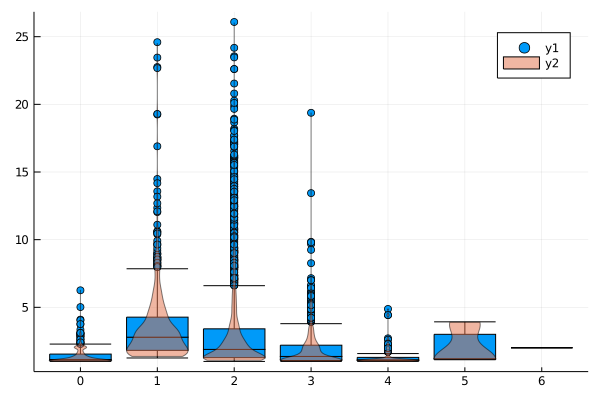

In [253]:
boxplot(minimum(paths[:,twodeg_nodes],dims=2),eff)
violin!(minimum(paths[:,twodeg_nodes],dims=2),eff,alpha=0.5)

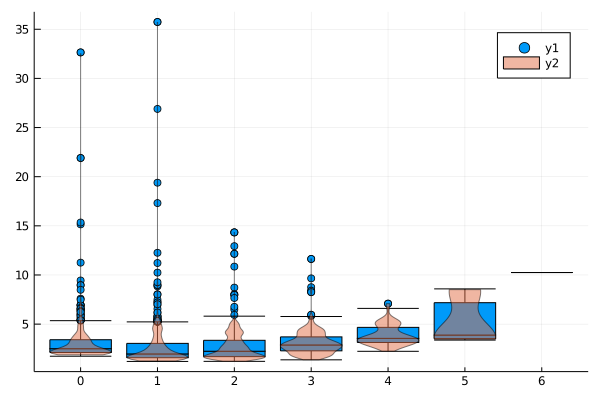

In [254]:
boxplot(minimum(paths[:,twodeg_nodes],dims=2),sens)
violin!(minimum(paths[:,twodeg_nodes],dims=2),sens,alpha=0.5)

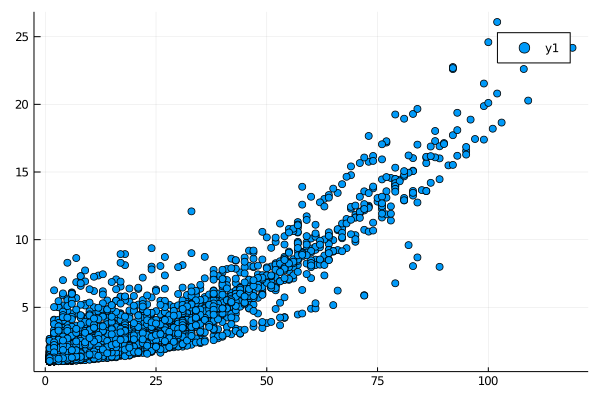

In [144]:
scatter(degree(gc),eff_)

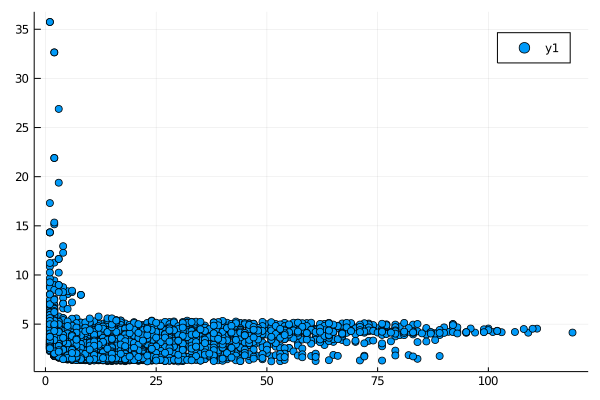

In [107]:
scatter(degree(gc),sens)